#  Analysis of susceptibility-temperature, <span style="font-family: 'Times New Roman';">*(Kappabridge $\chi$-T)*</span>, data

In this notebook, a contribution is downloaded from the MagIC database. Susceptibility-temperature (<span style="font-family: 'Times New Roman';">*$\chi$-T*</span>) data contained within it are extracted. The user has the option to correct for the diamagnetic signal of the measurement instrument and holder (optional) and to smooth the data prior to further analysis (optional).

The notebook is to be run cell-by-cell to allow users to select corrections/filters as needed. The code below brings in example magnetite data from the rock magnetic bestiary. Any MagIC contribution which contains <span style="font-family: 'Times New Roman';">*$\chi$-T*</span> data can be used in place of this example dataset.

### Install and import packages

Click inside the cell below, hold shift and then press enter. This will automatically run the script below.

In [1]:
import pmagpy.rockmag as rmag
import pmagpy.ipmag as ipmag
import pmagpy.contribution_builder as cb

from bokeh.io import output_notebook
output_notebook(hide_banner=True)

## Import data

We follow one of the approaches as in the `rockmag_data_unpack.ipynb` notebook to bring the MagIC data into the notebook as a Contribution.

In [2]:
#define these three parameters to match your data
magic_id = '20354'
share_key = '2f33e164-df55-4548-8d28-5b715683ae43'
dir_path = 'example_data/X-T'

result, magic_file = ipmag.download_magic_from_id(magic_id, directory=dir_path, share_key=share_key)
ipmag.unpack_magic(magic_file, dir_path, print_progress=False)
contribution = cb.Contribution(dir_path)
measurements = contribution.tables['measurements'].df

Download successful. File saved to: example_data/X-T/magic_contribution_20354.txt
1  records written to file  /Users/penokean/0000_GitHub/RockmagPy-notebooks/thermomagnetic_notebooks/example_data/X-T/contribution.txt
2  records written to file  /Users/penokean/0000_GitHub/RockmagPy-notebooks/thermomagnetic_notebooks/example_data/X-T/locations.txt
2  records written to file  /Users/penokean/0000_GitHub/RockmagPy-notebooks/thermomagnetic_notebooks/example_data/X-T/sites.txt
43  records written to file  /Users/penokean/0000_GitHub/RockmagPy-notebooks/thermomagnetic_notebooks/example_data/X-T/samples.txt
201  records written to file  /Users/penokean/0000_GitHub/RockmagPy-notebooks/thermomagnetic_notebooks/example_data/X-T/specimens.txt
92035  records written to file  /Users/penokean/0000_GitHub/RockmagPy-notebooks/thermomagnetic_notebooks/example_data/X-T/measurements.txt
-I- Using online data model
-I- Getting method codes from earthref.org
-I- Importing controlled vocabularies from https

## The project export contains data from all the experiments

Each measurement in a MagIC measurements table has a `method_codes` value. These method codes come from a "controlled vocabulary" (https://www2.earthref.org/MagIC/method-codes). 

In the method codes used for the example contribution:
- `LP` refers to lab protocol
- `X-T` refers to susceptibility vs. temperature experiments done on the Kappabridge

In [3]:
measurements = measurements[measurements['method_codes'] == 'LP-X-T']

## Select a <span style="font-family: 'Times New Roman';">*$\chi$-T*</span> Experiment
*Creates a dropdown to select specimens with <span style="font-family: 'Times New Roman';">*$\chi$*-T</span> data.*

In [4]:
specimen, experiment = rmag.interactive_specimen_experiment_selection(measurements)

Dropdown(description='specimen:', options=('magnetite_Wright 041183-k(T)-01', 'magnetite_Wright 112978-k(T)-01…

Dropdown(description='Experiment:', options=('IRM-KappaF-LP-X-T-3407',), value='IRM-KappaF-LP-X-T-3407')

## Plot $\chi$-T data

In [5]:
selected_experiment = measurements[(measurements['specimen']==specimen.value) & 
                                      (measurements['experiment']==experiment.value)].reset_index(drop=1)

rmag.plot_X_T(selected_experiment, 
              temp_unit='C', 
              remove_holder=True, 
              plot_smoothed=False,
              plot_derivative=False,
              plot_inverse=False,)

## Plot $\chi$-T data with smoothed curve and derivative

In [7]:
selected_experiment = measurements[measurements['experiment']=='IRM-KappaF-LP-X-T-3410'].reset_index(drop=1)

rmag.plot_X_T(selected_experiment, 
              temp_unit='C', 
              remove_holder=True, 
              plot_smoothed=True,
              plot_derivative=True,
              plot_inverse=False,)

In [ ]:
, the derivatives, and inverse $\chi$-T

- Your data might be noisy, which may hinder assessing reversibility for understanding alteration. The following code will perform a running average of data over a temperature interval that you can define. In the following cell, change the value associated with variable `temp_window` to set the desired temperature window for the running average.

- Holder removal: Set `remove_holder` parameter to be `True`. We assume that the lowest susceptibility value during the whole measurement is the holder signal, and that this happens after the specimen is heated above the critical temperature such that it is paramagnetic and the holder signal is dominant.

Three graphs will be created. 

(1) The top graph shows the raw data as points and the smoothed data as lines, for the temperature window size selected. 

(2) The second graph plots the derivatives based on the smoothed data in the top graph.

(3) The third graph plots the inverse susceptibility data, which can also be used to qualitatively assess the Curie temperature.

### Calculate <span style="font-family: 'Times New Roman';">*T<sub>c</sub>*</span> using inverse susceptibility

Above <span style="font-family: 'Times New Roman';">*T<sub>c</sub>*</span> a mineral phase will be paramagnetic. This means that the inverse susceptibility should have a linear positive slope above <span style="font-family: 'Times New Roman';">*T<sub>c</sub>*</span>. Using the intercept temperature at 0 inverse susceptibility is a good guess for  <span style="font-family: 'Times New Roman';">*T<sub>c</sub>*</span>. This is essentially the break of slope between the ferromagnetic and paramagnetic signal.

In [26]:
rmag.plot_X_T(selected_experiment, 
              temp_unit='C', 
              remove_holder=True, 
              smooth_window=20,
              plot_derivative=True,
              plot_inverse=False,)

## Determining the best temperature window for smoothing

The following function plots the **model roughness** against the **root mean square error** of the model **(note that the y-axis is inverted)** (a measure of the difference between the running average and the data). Each point on the graph is for a different temperature window size. The `knee` in the curve (the break of slope) can be interpreted as the optimal temperature window for smoothing. At this point (window) there is a decent trade off between the smoothness of the model (the running average) and error on the model.

Set values for `min_temp_window` and `max_temp_window` to set the temperature range for exploring the rms and variance tradeoff.

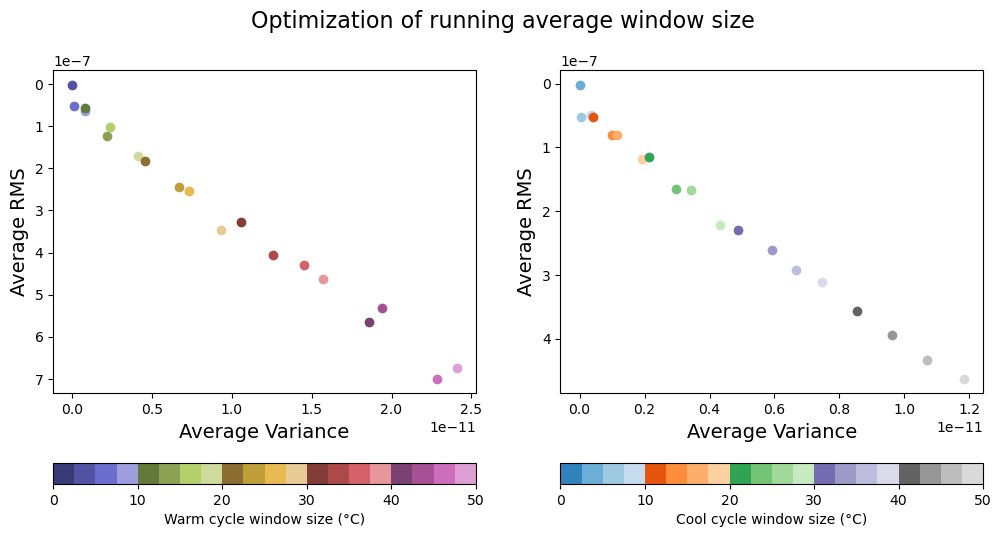

In [7]:
min_temp_window = 0
max_temp_window = 50
steps = 20
fig, ax = rmag.optimize_X_T_running_average_window(selected_experiment, min_temp_window, max_temp_window, steps=steps)

- upon inspecting the plot, a smoothing window size of about 10 K seems to be a good choice for this dataset.

In [8]:
# save the figure
fig.savefig("optimize_window_size.png")